In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from scipy.integrate import quad
from scipy.optimize import curve_fit

%matplotlib notebook

## EBIC Beam paremeters

In [2]:
q   = 1.602e-19# C
Ib  = 1E-3   # A Beam current
Eb  = 2      # meV Beam energy
eta = 1      # adsorbed fraction
Ei  = 10   # e-h formation energy

#G0 = eta/Ei

In [3]:
def Ic(Eb, tm, W, L, G0):
    """Returns Collection Efficiency value for given:
    
    Eb – Electron beam energy (eV)
    tm – Metal thickness (nm)
    W  – Screen charge region thickness (nm)
    L  – Diffusion length (nm)
    Ei – e-h formation energy
    """

    q  = 1.602e-19 # C
    Ib = 1e-3 # A
    n  = 1 # arb. units
    
    
    def A(z, Eb):
        R = 7.34*Eb**(1.75)#nm, Eb in keV
        return np.piecewise(z, 
                            [     z < 0.22*R,    z >= 0.22*R],
                            [lambda z: 12.84, lambda z: 3.97])

    def h(z, Eb):
        R = 7.34*Eb**(1.75)#nm, Eb in keV
        return 1.603/R*np.exp(-A(z, Eb)*(z/R - 0.22)**2)
    
    def hexp(z, Eb):
        R = 7.34*Eb**(1.75)#nm, Eb in keV
        return 1.603/R*np.exp(-A(z, Eb)*(z/R - 0.22)**2)*np.exp(-(z-W)/L)

    
    I1 = np.asarray([quad(   h, tm,      W, args=(_Eb), epsrel = 1e-2)[0] for _Eb in Eb])
    I2 = np.asarray([quad(hexp, tm, np.inf, args=(_Eb), epsrel = 1e-2)[0] for _Eb in Eb])
    I  = (I1 + I2)
    I = I*G0
    return I

# Plot data

## Fit data

In [4]:
def fit_data(path, tm, W, time = True):
    """Returns coefficients for fitted data
    
    path – path to data file
    tm – value of metal thickness for initial guess
    W – value of scr for initial guess
    
    """
    
    if time:
        import time 
        start = time.time()
    
    csv = np.loadtxt(path, delimiter = ',')
    
    E = csv[:,0]
    Imax = max(csv[:,1])
    I = csv[:,1]#/Imax ## normalized
    
    X = 7.34*E**(1.75) ##nm, E in keV
    
    guess = [tm, W, 51, 1.]
    bounds = ([1.0, 100.0, 5.0, 1e-3], [250.0, 5.0E4, 850, 100.])
    
    popt, pcov = curve_fit(Ic, E, I, p0 = guess, bounds = bounds) 
    err = np.sqrt(np.diag(pcov))
    #print('optimal = ', popt)
    #print('err = ', err)
    print('Metal thickness : %.2f nm\n'%(popt[0]),
          'SCR width : %.2f nm\n'%(popt[1]),
          'Diffusion length : %.2f ± %.2f nm\n'%(popt[2], err[2]),
          'η/Ei :%.2f ± %.2f eV-1'%(popt[3], err[3]))

    if time:
        print('-----------------------------------------')
        end = time.time()
        print('Elapsed time: %.2f s'%(end - start))
        
    return E, I, Ic(E, *popt), popt

### S1 data fitting

In [5]:
data = []
path = 'data/S1.csv'
E, I_data, I_fit, params = fit_data(path = path, tm = 40, W = 500)
data.append([E, I_data, I_fit, params, path])

Metal thickness : 42.53 nm
 SCR width : 556.85 nm
 Diffusion length : 146.53 ± 50.82 nm
 η/Ei :1.21 ± 7.73 eV-1
-----------------------------------------
Elapsed time: 17.07 s


<IPython.core.display.Javascript object>


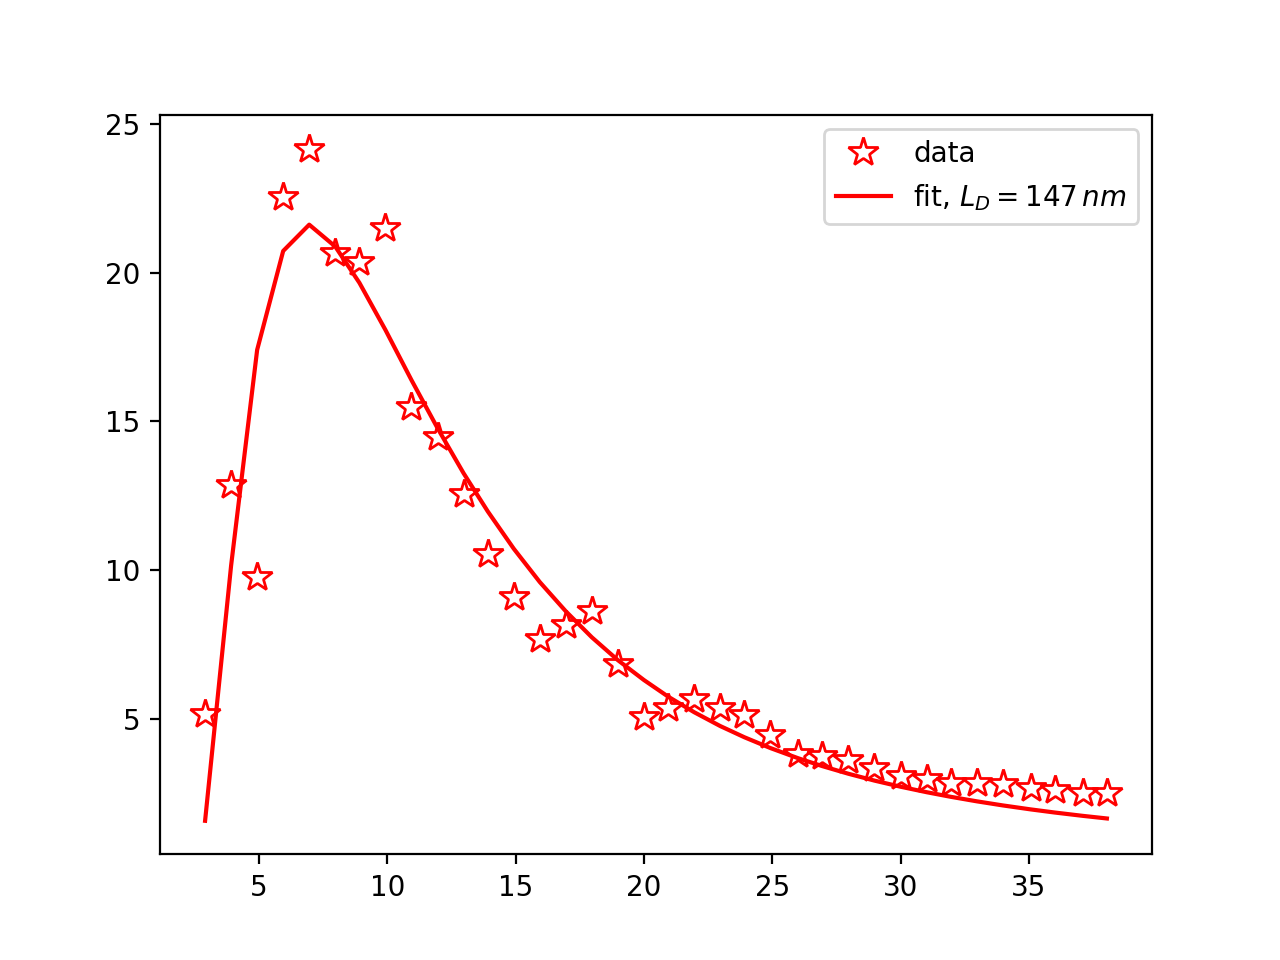

In [6]:
fig = plt.figure()
plt.plot(E, I_data, 'r*', label = r'data', ms = 11, mfc='none')
plt.plot(E, I_fit,  'r-', label = r'fit, $L_D = %.0f \,nm$'%params[2])
plt.legend()

### S3 data fitting

In [7]:
path = 'data/S3.csv'
E, I_data, I_fit, params = fit_data(path = path, tm = 80, W = 500)
data.append([E, I_data, I_fit, params, path])

Metal thickness : 165.65 nm
 SCR width : 1815.85 nm
 Diffusion length : 556.93 ± 0.00 nm
 η/Ei :0.80 ± 0.72 eV-1
-----------------------------------------
Elapsed time: 16.16 s


<IPython.core.display.Javascript object>


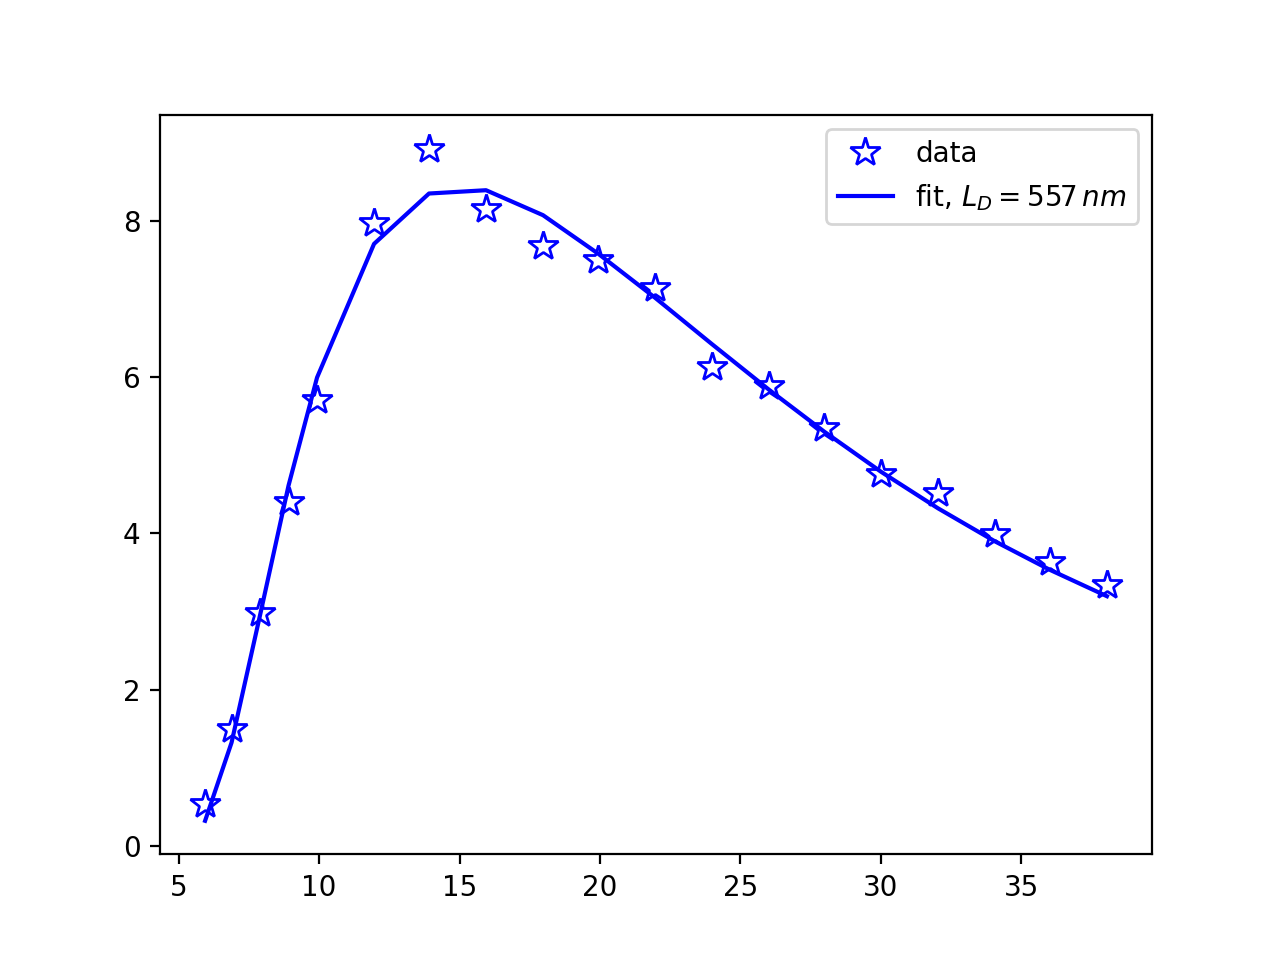

In [8]:
fig = plt.figure()
plt.plot(E, I_data, 'b*', label = r'data', ms = 11, mfc='none')
plt.plot(E, I_fit,  'b-', label = r'fit, $L_D = %.0f \,nm$'%params[2])
plt.legend()

### S2 data fitting

In [9]:
path = 'data/S2.csv'
E, I_data, I_fit, params = fit_data(path = path, tm = 40, W = 500)
data.append([E, I_data, I_fit, params, path])

Metal thickness : 28.77 nm
 SCR width : 375.10 nm
 Diffusion length : 105.64 ± 9.91 nm
 η/Ei :0.91 ± 1.50 eV-1
-----------------------------------------
Elapsed time: 11.38 s


<IPython.core.display.Javascript object>


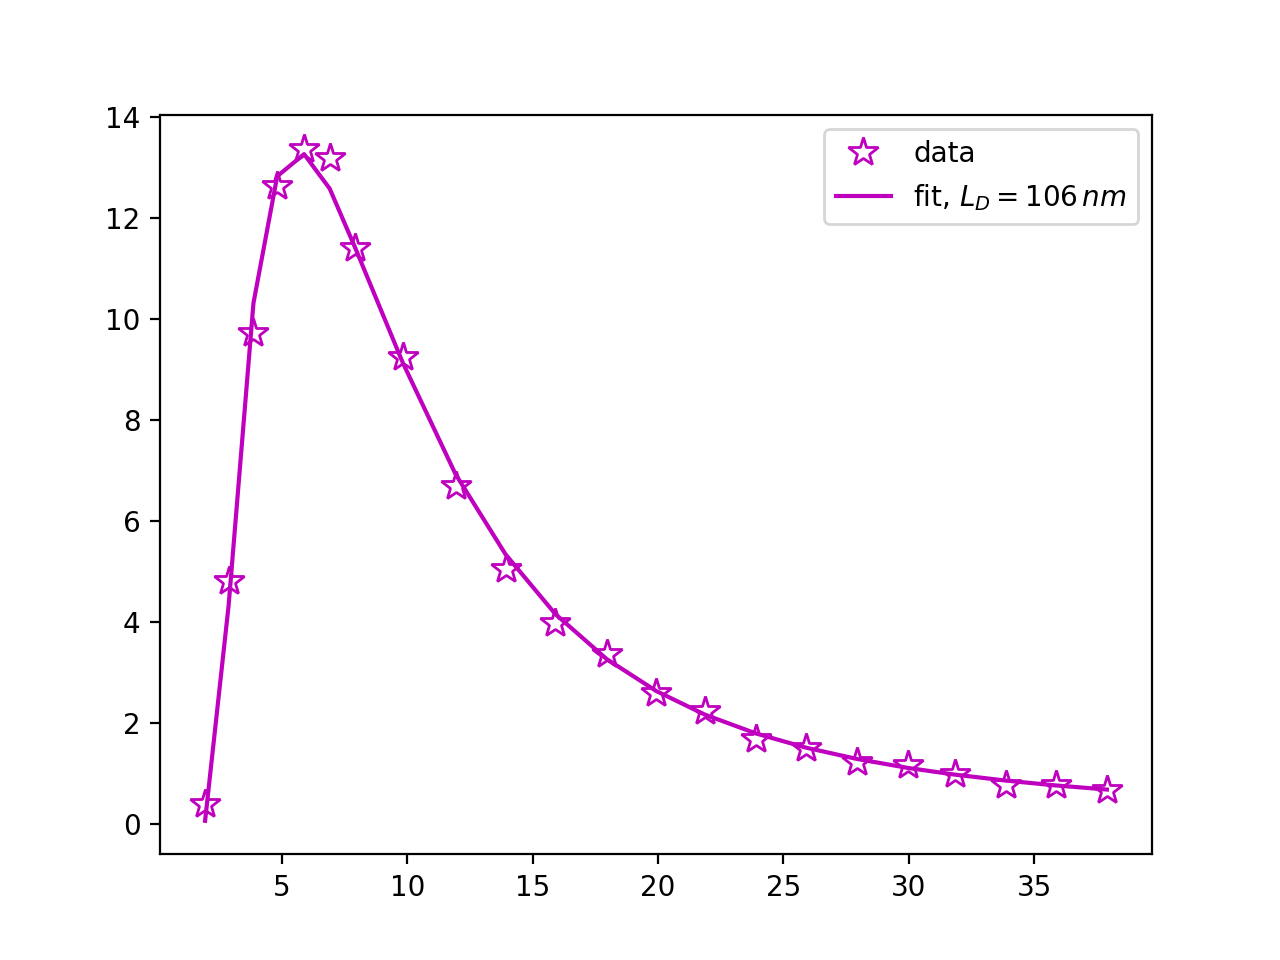

In [10]:
fig = plt.figure()
plt.plot(E, I_data, 'm*', label = r'data', ms = 11, mfc='none')
plt.plot(E, I_fit,  'm-', label = r'fit, $L_D = %.0f \,nm$'%params[2])
plt.legend()

### S4 data Fitting

In [11]:
path = 'data/S4.csv'
E, I_data, I_fit, params = fit_data(path = path, tm = 40, W = 500)
data.append([E, I_data, I_fit, params, path])

Metal thickness : 12.37 nm
 SCR width : 1263.83 nm
 Diffusion length : 487.45 ± 171.21 nm
 η/Ei :0.49 ± 2.03 eV-1
-----------------------------------------
Elapsed time: 20.39 s


<IPython.core.display.Javascript object>


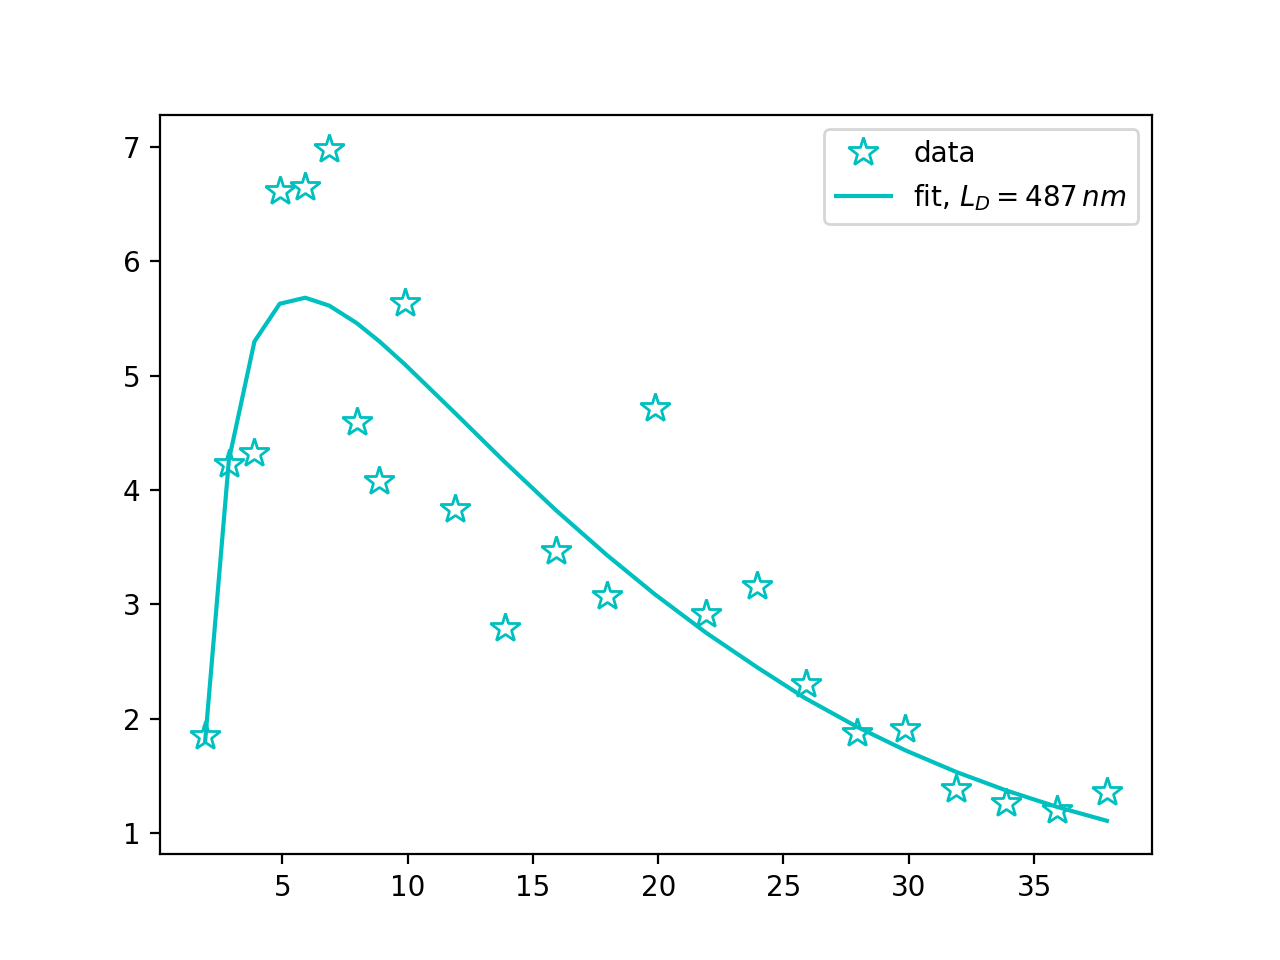

In [12]:
fig = plt.figure()
plt.plot(E, I_data, 'c*', label = r'data', ms = 11, mfc='none')
plt.plot(E, I_fit,  'c-', label = r'fit, $L_D = %.0f \,nm$'%params[2])
plt.legend()

### Alpha

In [13]:
path = 'data/alpha.csv'
E, I_data, I_fit, params = fit_data(path = path, tm = 40, W = 500)
data.append([E, I_data, I_fit, params, path])

Metal thickness : 38.26 nm
 SCR width : 466.45 nm
 Diffusion length : 151.46 ± 15.37 nm
 η/Ei :3.80 ± 6.85 eV-1
-----------------------------------------
Elapsed time: 15.75 s


<IPython.core.display.Javascript object>


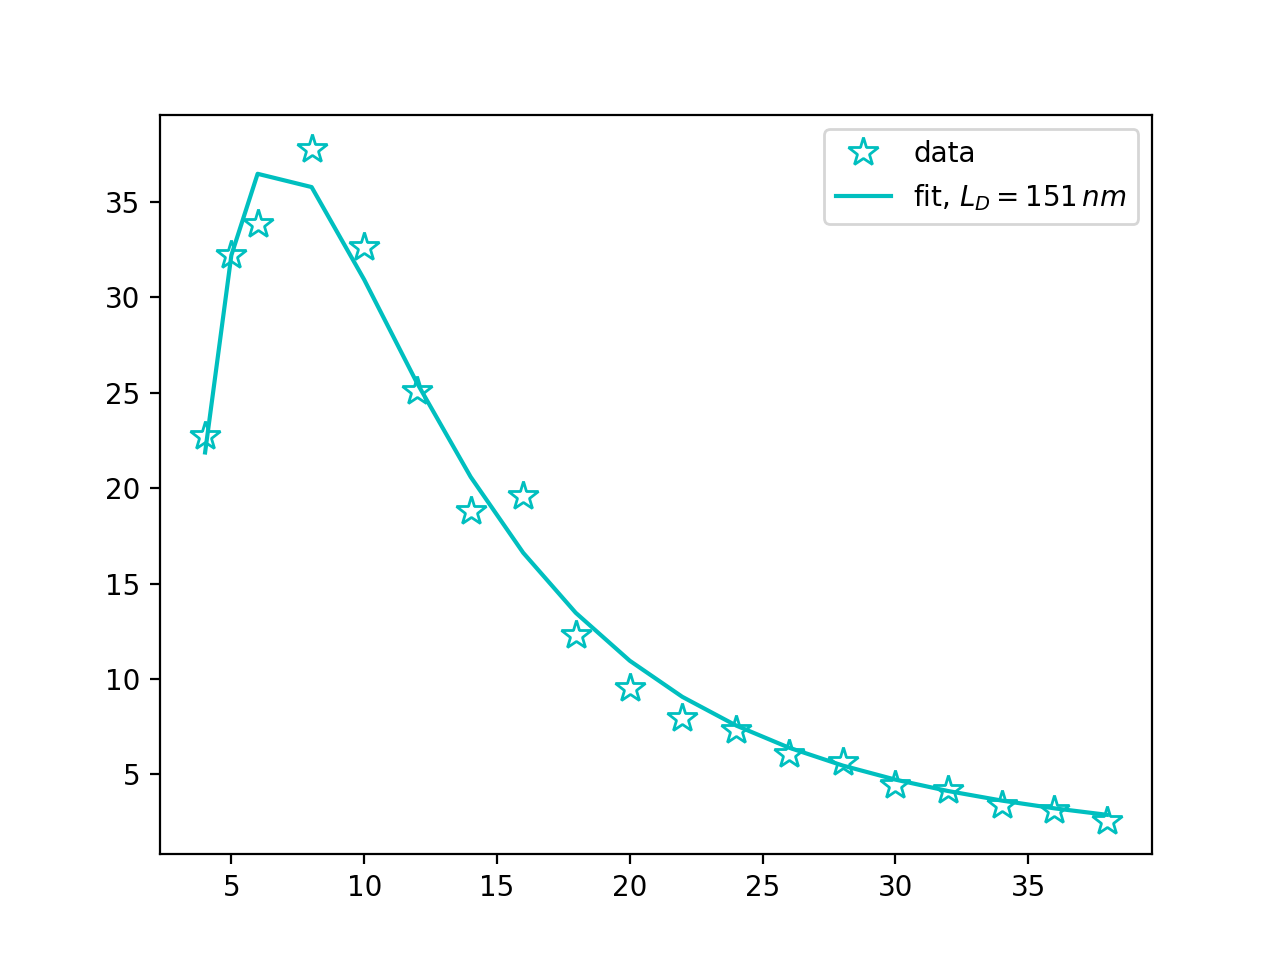

In [14]:
fig = plt.figure()
plt.plot(E, I_data, 'c*', label = r'data', ms = 11, mfc='none')
plt.plot(E, I_fit,  'c-', label = r'fit, $L_D = %.0f \,nm$'%params[2])
plt.legend()

### Total

<IPython.core.display.Javascript object>


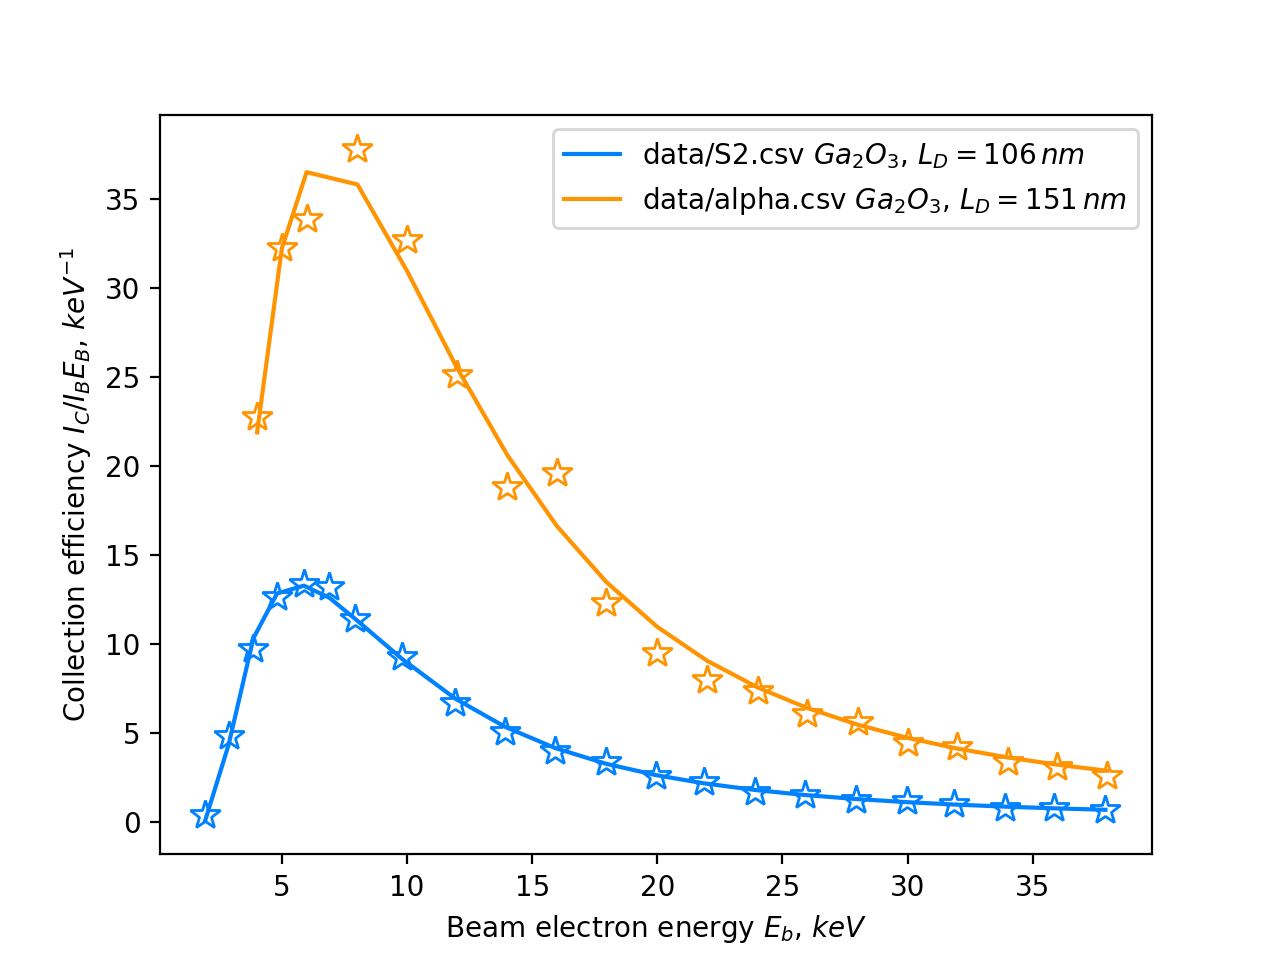

In [15]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_xlabel(r'Beam electron energy $E_b$, $keV$')
ax.set_ylabel(r'Collection efficiency $I_C / I_B E_B$, ${keV}^{-1}$')
c  = cm.jet(np.linspace(0, 1, len(data)))
p = [2, 4]
for i in p:
    E, I_data, I_fit, params, path = data[i]
    ax.plot(E, I_data, '*', c = c[i-1], ms = 11, mfc='none')
    ax.plot(E, I_fit,  '-', c = c[i-1], label = path + r' $Ga_2 O_3$' + r', $L_D = %.0f \,nm$'%params[2])
ax.legend()
#plt.savefig('diff_length.svg')